<a href="https://colab.research.google.com/github/GardnerL16/GardnerL16.github.io/blob/master/HW_p4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install celluloid
! pip install torch

In [7]:
# Libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import numpy as np
from celluloid import Camera
from IPython.display import HTML
%matplotlib inline

In [6]:
def cuda2numpy(a):
    return a.data.detach().cpu().numpy()

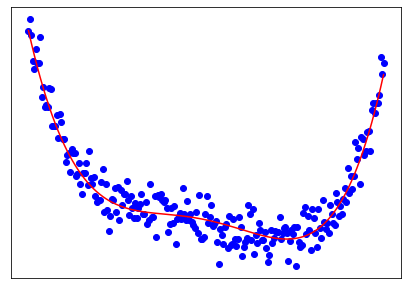

In [ ]:
moon=cv2.imread("moon.jpg")




x = torch.arange(-6.0, 6.0, 0.05)
N=x.shape[0]
##You can adjust the slope and intercept to verify the changes in the graph
y = .1*(x**3) - 2*((x+2)**2) + 1*x + 3+0.2*(x)**4
y_noise = 15 * torch.randn(N)
ydata = y + y_noise
plt.figure(figsize=(7,5))
plt.plot(x, ydata,  'bo')
plt.plot(x,y, 'r')
plt.xticks([]);plt.yticks([])

ydata=ydata.unsqueeze(1)
x=x.unsqueeze(1)

In [ ]:
class MLP(nn.Module):
  def __init__(self,architecture=[1,100,1],activation='sigmoid'):
        super(MLP, self).__init__()
        self.architecture=architecture
        if activation=='sigmoid':
          self.activation=nn.Sigmoid()
        elif activation=='relu':
          self.activation=nn.ReLU()
        else:
          print('Activation not recognized! Using LeakyReLU instead.')
          self.activation=nn.LeakyReLU()
        arch=[]
        for i in range(1,len(architecture)-1):
            arch.append(nn.Linear(architecture[i-1],architecture[i]))
            arch.append(self.activation)
        self.basis=nn.Sequential(*arch)
        self.regressor=nn.Linear(architecture[-2],architecture[-1])

  def forward(self,f):
        assert f.shape[1]==self.architecture[0]
        z=self.basis(f)
        out=self.regressor(z)
        return out

In [ ]:
lr=1e-2
n_epochs=7500
model=MLP([1,25,1],activation='sigmoid')
optim=torch.optim.SGD(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim,milestones=[1000,
                                                                   2500,5000],
                                                  gamma=0.5)

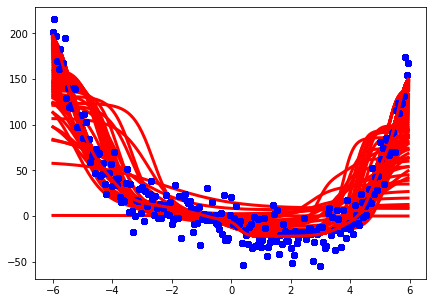

In [ ]:
objective=nn.MSELoss()
fig=plt.figure(figsize=(7,5))
camera=Camera(fig)
for n in range(n_epochs):
  f=model(x)
  loss=objective(f,ydata)
  optim.zero_grad()
  loss.backward()
  optim.step()
  if np.mod(n,25)==0:
    plt.plot(x, ydata,  'bo')
    plt.plot(x,cuda2numpy(f), 'r',linewidth=3)
    camera.snap()
  scheduler.step()

In [ ]:
# Create animation
anim = camera.animate(interval = 40, repeat = True, repeat_delay = 500)
# Inline display
HTML(anim.to_html5_video())

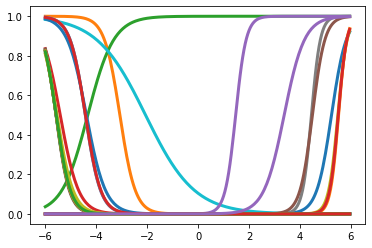

In [ ]:
basis=cuda2numpy(model.basis(x))
for i in range(basis.shape[1]):
  plt.plot(x,basis[:,i],linewidth=3)
plt.show()